### Check influence of different parameters in performance. 

Check influence of:
- specifying different chunk sizes and chunking along different dimensions
- use already standardized data --> does it save memory?
- use ``` .persist()``` to load data in a distributed way and speed up reading



In [1]:
standardization_contants = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import healpy as hp
import random

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.utils import train_model_2steps, init_device
from modules.data import WeatherBenchDatasetXarrayHealpix
from modules.healpix_models import UNetSphericalHealpix
from modules.test import create_iterative_predictions_healpix
from modules.test import compute_rmse_healpix
from modules.plotting import plot_rmses

datadir = "../data/healpix/"
input_dir = datadir + "5.625deg_nearest/"
model_save_path = datadir + "models/"
pred_save_path = datadir + "predictions/"
input_dir_vars = datadir + "5.625deg_chunks/"

train_years = ('1979', '2012')
val_years = ('2013', '2016')
test_years = ('2017', '2018')

nodes = 12*16*16
max_lead_time = 5*24
lead_time = 6
out_features = 2
nb_timesteps = 2
len_sqce = 2
# define time resolution
delta_t = 6

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
gpu = [0,1]
num_workers = 10
pin_memory = True
batch_size = 95

nb_epochs = 10
learning_rate = 8e-3


In [5]:
from modules.data import WeatherBenchDatasetIterative
class WeatherBenchDatasetXarrayHealpixTemp(Dataset):
    
    """ Dataset used for graph models (1D), where data is loaded from stored numpy arrays.
    
    Parameters
    ----------
    ds : xarray Dataset
        Dataset containing the input data
    out_features : int
        Number of output features
    delta_t : int
        Temporal spacing between samples in temporal sequence (in hours)
    len_sqce : int
        Length of the input and output (predicted) sequences
    years : tuple(str)
        Years used to split the data
    nodes : float
        Number of nodes each sample has
    max_lead_time : int
        Maximum lead time (in case of iterative predictions) in hours
    load : bool
        If true, load dataset to RAM
    mean : np.ndarray of shape 2
        Mean to use for data normalization. If None, mean is computed from data
    std : np.ndarray of shape 2
        std to use for data normalization. If None, mean is computed from data
    """
        
    def __init__(self, ds, out_features, delta_t, len_sqce, years, nodes, nb_timesteps, 
                 max_lead_time=None, load=False, mean=None, std=None, standardize=True):
        
        
        self.delta_t = delta_t
        self.len_sqce = len_sqce
        self.years = years
        
        self.nodes = nodes
        self.out_features = out_features
        self.max_lead_time = max_lead_time
        self.nb_timesteps = nb_timesteps
        
        self.data = ds.to_array(dim='level', name='Dataset').transpose('time', 'node', 'level')
        
        self.in_features = self.data.shape[-1]
        
        if standardize:
            self.mean = self.data.mean(('time', 'node')).compute() if mean is None else mean
            self.std = self.data.std(('time', 'node')).compute() if std is None else std
        
        eps = 0.001 #add to std to avoid division by 0
        
        # Count total number of samples
        total_samples = self.data.shape[0]        
        
        if max_lead_time is None:
            self.n_samples = total_samples - (len_sqce+1) * delta_t
        else:
            self.n_samples = total_samples - (len_sqce+1) * delta_t - max_lead_time
        
        # Normalize
        if standardize:
            self.data = (self.data - self.mean.to_array(dim='level')) / (self.std.to_array(dim='level') + eps)
        
        self.data.persist()
        self.idxs = np.array(range(self.n_samples))
        
        if load:
            print('Loading data to RAM...')
            self.data.load()
        
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, len_sqce, n_features]
            
        """
        idx_data = idx#self.idxs[idx]
        #1,0,2
        
        #batch[0] --> (batch_size, num_nodes, n_features*len_sq)
        idx_full = np.concatenate([idx_data+delta_t,  idx_data + delta_t * len_sqce, idx_data + delta_t * (len_sqce+1)])
        dat = self.data.isel(time=idx_full).values
        
        
        X = (
            torch.tensor(dat[:len(idx),:,:] , \
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),
        )
        
        y = (torch.tensor(dat[len(idx):len(idx)*2,:,:],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1),\
             torch.tensor(dat[len(idx)*2:,:,:out_features],\
                         dtype=torch.float).reshape(len(idx), self.nodes, -1)
        
        )
        return X, y 

Define model

In [6]:
#description = "no_const"
description = "all_const_hd5"

model_filename = model_save_path + "spherical_unet_" + description + ".h5"
pred_filename = pred_save_path + "spherical_unet_" + description + ".nc"
rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'

In [8]:
# Model #old: in_channels=in_features*len_sqce
spherical_unet = UNetSphericalHealpix(N=nodes, in_channels=7, out_channels=2, 
                                      kernel_size=3)
spherical_unet, device = init_device(spherical_unet, gpu=gpu)

In [9]:
def train_model_2steps_custom(model, device, training_ds, constants, batch_size, epochs, lr, validation_ds):    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    train_losses = []
    val_losses = []
    n_samples = training_ds.n_samples
    n_samples_val = validation_ds.n_samples
    num_nodes = training_ds.nodes
    num_constants = constants.shape[1]
    out_features = training_ds.out_features
    
    constants_expanded = constants.expand(batch_size, num_nodes, num_constants)
    constants1 = constants_expanded.to(device)
    idxs_val = validation_ds.idxs
    
    for epoch in range(epochs):
        
        print('\rEpoch : {}'.format(epoch), end="")
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()  
        
        random.shuffle(training_ds.idxs)
        idxs = training_ds.idxs
        
        batch_idx = 0
        times_read = []
        for i in range(0, n_samples - batch_size, batch_size):
            i_next = min(i + batch_size, n_samples)
            
            if len(idxs[i:i_next]) < batch_size:
                constants_expanded = contants.expand(len(idxs[i:i_next]), num_nodes, num_constants)
                constants1 = constants_expanded.to(device)
        
            
            t1 = time.time()
            batch, labels = training_ds[idxs[i:i_next]]
            
            t2 = time.time()
            
            # Transfer to GPU
            
            
            batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
            label1 = labels[0].to(device)
            label2 = labels[1].to(device)
            
            
            t3 = time.time()
            batch_size = batch1.shape[0]
            
            # Model
            
            t4 = time.time()
            output1 = model(batch1)  
            t5 = time.time()
            batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
            t6 = time.time()
            output2 = model(batch2)
            t7 = time.time()
            loss = criterion(output1, label1[:,:,:out_features]) + criterion(output2, label2)
            t8 = time.time()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
            
            print('\nTime to read batch: {}s'.format(t2-t1))
            print('Time to transfer data to GPU: {}s'.format(t3-t2))
            print('Time to process input 1: {}s'.format(t5-t4))
            print('Time to process input 2: {}s'.format(t7-t6))
            print('Time to compute loss: {}s'.format(t8-t7))
            print('\n')
            print('\rBatch idx: {}; Loss: {:.3f}'.format(batch_idx, train_loss/(batch_size*(batch_idx+1))), end="")
            times_read.append(t2-t1)
            
            if len(times_read) == 10: 
                print('Reading time: {} +- {}'.format(np.mean(times_read), np.std(times_read)))
                return times_read
            batch_idx += 1
        
        train_loss = train_loss / n_samples
        train_losses.append(train_loss)
        
        model.eval()
        
        constants1 = constants_expanded.to(device)
        with torch.set_grad_enabled(False):
            index = 0
            
            for i in range(0, n_samples_val - batch_size, batch_size):
                i_next = min(i + batch_size, n_samples_val)

                if len(idxs_val[i:i_next]) < batch_size:
                    constants_expanded = contants.expand(len(idxs_val[i:i_next]), num_nodes, num_constants)
                    constants1 = constants_expanded.to(device)


                #t1 = time.time()
                batch, labels = validation_ds[idxs_val[i:i_next]]
                # Transfer to GPU
                batch1 = torch.cat((batch[0], constants_expanded), dim=2).to(device)
                label1 = labels[0].to(device)
                label2 = labels[1].to(device)

                batch_size = batch1.shape[0]
                
                output1 = model(batch1)
                batch2 = torch.cat((output1, label1[:,:,-1].view(-1, num_nodes, 1), constants1), dim=2)
                output2 = model(batch2)
                
                val_loss = val_loss + (criterion(output1, label1[:,:,:out_features]).item() 
                                       + criterion(output2, label2).item()) * batch_size
                index = index + batch_size
                
        val_loss = val_loss / n_samples_val
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
        
    return train_losses, val_losses

## Explore effect of different parameters on the training time

|  Experiment  | chunk size | preload in memory | read standardized data |  engine  |
|:--:|:----------:|:-----------------:|:----------------------:|:--------:|
|  1 |     512    |         No        |           No           |  netcdf4 |
|  2 |     512    |        Yes        |           No           |  netcdf4 |
|  3 |    1042    |         No        |           No           |  netcdf4 |
|  4 |    1042    |        Yes        |           No           |  netcdf4 |
|  5 |     512    |         No        |           Yes          |  netcdf4 |
|  6 |     512    |        Yes        |           Yes          |  netcdf4 |
|  7 |    1042    |         No        |           Yes          |  netcdf4 |
|  8 |    1042    |        Yes        |           Yes          |  netcdf4 |
|  9 |     512    |         No        |           No           | h5netcdf |
| 10 |     512    |        Yes        |           No           | h5netcdf |
| 11 |     1(no chunking)|         No        |           No           | netcdf4 |
| 12 |     1(no chunking)|        Yes        |           No           | netcdf4 |
| 13 |     512, 32|             No        |           No           |  netcdf4 |
| 14 |     512, 32|        Yes        |           No           |  netcdf4 |
| 15 |     260    |         No        |           No           | netcdf4 |
| 16 |     130    |         No        |           No           | netcdf4 |
| 17 |     50     |         No        |           No           | netcdf4 |

In [10]:
class results_time():
    def __init__(self, time, chunk_size, memory, standardization):
        self.times = time
        self.chunk_size = chunk_size
        self.loaded_in_memory = memory
        self.standardized = standardization
        self.mean_time = np.mean(time)
        self.std_time = np.std(time)
        self.max_time = np.max(time)
        self.min_time = np.min(time)
        
    def print(self):
        print('Parameters: \n\t* Chunk size: {}\n\t* Loaded in memory: {}\n\t* Previously standardized: {}'.\
             format(self.chunk_size, self.loaded_in_memory, self.standardized))
        print('Loading time: {:.3f}s $\pm$ {:.3f}'.format(self.mean_time, self.std_time))
        

In [ ]:
z500 = xr.open_mfdataset(f'{input_dir}geopotential_500/*.nc', combine='by_coords', \
                                 chunks={'time':chunk_size}, parallel=False, engine=engine).rename({'z':'z500'})

In [10]:


z500 = xr.open_dataset(f'{input_dir}geopotential_500/geopotential_500_5.625deg.nc', \
                                 chunks={'time':1000}).rename({'z':'z500'})

In [11]:
def generate_comparison(chunk_size, load_ram, data_standardized, \
                        chunk_size_space=0, engine='netcdf4', chunk=True, single=False, input_dir_=datadir + "5.625deg_nearest/"):
    if chunk and not single:
        
        if chunk_size_space == 0:
            z500 = xr.open_mfdataset(f'{input_dir_}geopotential_500/*.nc', combine='by_coords', \
                                 chunks={'time':chunk_size}, parallel=False, engine=engine).rename({'z':'z500'})
            t850 = xr.open_mfdataset(f'{input_dir_}temperature_850/*.nc', combine='by_coords', \
                                     chunks={'time':chunk_size}, parallel=False, engine=engine).rename({'t':'t850'})
            rad = xr.open_mfdataset(f'{input_dir_}toa_incident_solar_radiation/*.nc', combine='by_coords', \
                                    chunks={'time':chunk_size}, parallel=False, engine=engine)
        else:
            z500 = xr.open_mfdataset(f'{input_dir_}geopotential_500/*.nc', combine='by_coords', \
                                 chunks={'time':chunk_size, 'node':chunk_size_space}, \
                                     parallel=False, engine=engine).rename({'z':'z500'})
            t850 = xr.open_mfdataset(f'{input_dir_}temperature_850/*.nc', combine='by_coords', \
                                     chunks={'time':chunk_size, 'node':chunk_size_space}, \
                                     parallel=False, engine=engine).rename({'t':'t850'})
            rad = xr.open_mfdataset(f'{input_dir_}toa_incident_solar_radiation/*.nc', combine='by_coords', \
                                    chunks={'time':chunk_size, 'node':chunk_size_space}, \
                                    parallel=False, engine=engine)

        
        
    if not chunk and not single:
        z500 = xr.open_mfdataset(f'{input_dir_}geopotential_500/*.nc', combine='by_coords', \
                              parallel=False, engine=engine).rename({'z':'z500'})
        t850 = xr.open_mfdataset(f'{input_dir_}temperature_850/*.nc', combine='by_coords', \
                              parallel=False, engine=engine).rename({'t':'t850'})
        rad = xr.open_mfdataset(f'{input_dir_}toa_incident_solar_radiation/*.nc', combine='by_coords', \
                              parallel=False, engine=engine)
    
    if single:
        z500 = xr.open_dataset(f'{input_dir_vars}geopotential_500/geopotential_500_5.625deg.nc', \
                                 chunks={'time':chunk_size}).rename({'z':'z500'})
        
        t850 = xr.open_dataset(f'{input_dir_vars}temperature_850/temperature_850_5.625deg.nc', \
                                chunks={'time':chunk_size}, engine=engine).rename({'t':'t850'})
        rad = xr.open_dataset(f'{input_dir_vars}toa_incident_solar_radiation/toa_incident_solar_radiation_5.625deg.nc', \
                                chunks={'time':chunk_size}, engine=engine)

    z500 = z500.isel(time=slice(7, None))
    t850 = t850.isel(time=slice(7, None))

    constants = xr.open_dataset(f'{input_dir}constants/constants_5.625deg_standardized.nc', engine=engine)
    orog = constants['orog']
    lsm = constants['lsm']
    lats = constants['lat2d']
    slt = constants['slt']
    cos_lon = constants['cos_lon']
    sin_lon = constants['sin_lon']

    num_constants = len([orog, lats, lsm, slt])
    constants_tensor = torch.tensor(xr.merge([orog, lats, lsm, slt], compat='override').to_array().values, \
                                dtype=torch.float)
    
    
    in_features = 7 #len(feature_idx)
    train_mean_ = xr.open_mfdataset(f'{input_dir}mean_train_features_dynamic.nc', engine=engine)
    train_std_ = xr.open_mfdataset(f'{input_dir}std_train_features_dynamic.nc', engine=engine)
    
    if data_standardized:
        ds = xr.merge([z500, t850, rad], compat='override')
        #ds = xr.merge([z500, t850, orog, lats, lsm, slt, rad], compat='override')

        ds_train = ds.sel(time=slice(*train_years))
        ds_valid = ds.sel(time=slice(*val_years))
        ds_test = ds.sel(time=slice(*test_years))
    
    else:
        ds = xr.open_mfdataset(f'{input_dir}ds_standardized.nc', engine=engine)

        ds_train = ds.sel(time=slice(*train_years))
        ds_valid = ds.sel(time=slice(*val_years))
        ds_test = ds.sel(time=slice(*test_years))
    
    # Train and validation data
    training_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_train, out_features=out_features, delta_t=delta_t,
                                                       len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                       years=train_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                       mean=train_mean_, std=train_std_, load=load_ram, standardize=data_standardized)
    validation_ds = WeatherBenchDatasetXarrayHealpixTemp(ds=ds_valid, out_features=out_features, delta_t=delta_t,
                                                         len_sqce=len_sqce, max_lead_time=max_lead_time,
                                                         years=val_years, nodes=nodes, nb_timesteps=nb_timesteps, 
                                                         mean=train_mean_, std=train_std_, load=load_ram, standardize=data_standardized)

    
    torch.cuda.empty_cache()
    
    times1 = train_model_2steps_custom(spherical_unet, device, training_ds, constants_tensor.transpose(1,0), batch_size, epochs=7, \
                                           lr=learning_rate, validation_ds=validation_ds)
    
    
    t1 = results_time(times1, chunk_size, load_ram, data_standardized)
    del z500, t850, ds, ds_train, ds_valid, ds_test, training_ds, validation_ds
    return t1

### Option 0. 

* chunk size = 500
* data loaded to memory = False
* data previously standardized = False
* open reading single file

In [24]:
chunk_size = 500#483*2 #483
load_ram = False
data_standardized = False

In [25]:
times0 = generate_comparison(chunk_size, load_ram, data_standardized, single=True)


Epoch : 0
Time to read batch: 16.58344078063965s
Time to transfer data to GPU: 0.00795125961303711s
Time to process input 1: 0.40342020988464355s
Time to process input 2: 0.10130858421325684s
Time to compute loss: 0.05910897254943848s


Batch idx: 0; Loss: 3730.204
Time to read batch: 16.584738969802856s
Time to transfer data to GPU: 0.005679130554199219s
Time to process input 1: 0.036611318588256836s
Time to process input 2: 0.04069375991821289s
Time to compute loss: 0.1487901210784912s


Batch idx: 1; Loss: 3713.430
Time to read batch: 16.577887296676636s
Time to transfer data to GPU: 0.00514674186706543s
Time to process input 1: 0.03957200050354004s
Time to process input 2: 0.036846160888671875s
Time to compute loss: 0.14819097518920898s


Batch idx: 2; Loss: 3686.326
Time to read batch: 16.675358772277832s
Time to transfer data to GPU: 0.010871410369873047s
Time to process input 1: 0.03976154327392578s
Time to process input 2: 0.04721975326538086s
Time to compute loss: 0.1544075012

### Option 1. 

* chunk size = 521
* data loaded to memory = False
* data previously standardized = False

In [11]:
chunk_size = 521#483*2 #483
load_ram = False
data_standardized = True

In [12]:
times1 = generate_comparison(chunk_size, load_ram, data_standardized)


Epoch : 0
Time to read batch: 2.9535136222839355s
Time to transfer data to GPU: 0.005295991897583008s
Time to process input 1: 2.743197202682495s
Time to process input 2: 0.10759162902832031s
Time to compute loss: 0.050592899322509766s


Batch idx: 0; Loss: 17.112
Time to read batch: 2.3168036937713623s
Time to transfer data to GPU: 0.005452871322631836s
Time to process input 1: 0.04282093048095703s
Time to process input 2: 0.042311906814575195s
Time to compute loss: 0.14772558212280273s


Batch idx: 1; Loss: 12.816
Time to read batch: 2.5945050716400146s
Time to transfer data to GPU: 0.004836082458496094s
Time to process input 1: 0.03872203826904297s
Time to process input 2: 0.03999614715576172s
Time to compute loss: 0.15098357200622559s


Batch idx: 2; Loss: 10.095
Time to read batch: 2.7010977268218994s
Time to transfer data to GPU: 0.0048215389251708984s
Time to process input 1: 0.04067587852478027s
Time to process input 2: 0.051154136657714844s
Time to compute loss: 0.144152641296

### Option 2. 

* chunk size = 521
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [13]:
chunk_size = 521#483*2 #483
load_ram = True
data_standardized = True

In [14]:
times2 = generate_comparison(chunk_size, load_ram, data_standardized)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.024421215057373047s
Time to transfer data to GPU: 0.004256486892700195s
Time to process input 1: 0.11692118644714355s
Time to process input 2: 0.12482452392578125s
Time to compute loss: 0.03869342803955078s


Batch idx: 0; Loss: 1.615
Time to read batch: 0.031793832778930664s
Time to transfer data to GPU: 0.004853487014770508s
Time to process input 1: 0.03521156311035156s
Time to process input 2: 0.03869032859802246s
Time to compute loss: 0.15381669998168945s


Batch idx: 1; Loss: 3.965
Time to read batch: 0.026147842407226562s
Time to transfer data to GPU: 0.0046443939208984375s
Time to process input 1: 0.03661322593688965s
Time to process input 2: 0.03917717933654785s
Time to compute loss: 0.15212011337280273s


Batch idx: 2; Loss: 4.079
Time to read batch: 0.022969484329223633s
Time to transfer data to GPU: 0.0045490264892578125s
Time to process input 1: 0.036415815353393555s
Time to process input 2: 0.037

### Option 3. 

* chunk size = 1042
* data loaded to memory = False
* data previously standardized = False --> data_standardized = True

In [15]:
chunk_size = 1042#483*2 #483
load_ram = False
data_standardized = True

In [16]:
times3 = generate_comparison(chunk_size, load_ram, data_standardized)

Epoch : 0
Time to read batch: 5.682690143585205s
Time to transfer data to GPU: 0.004765748977661133s
Time to process input 1: 0.13182783126831055s
Time to process input 2: 0.1200106143951416s
Time to compute loss: 0.03840994834899902s


Batch idx: 0; Loss: 1.364
Time to read batch: 5.312511682510376s
Time to transfer data to GPU: 0.005370140075683594s
Time to process input 1: 0.041658639907836914s
Time to process input 2: 0.04047250747680664s
Time to compute loss: 0.148512601852417s


Batch idx: 1; Loss: 1.826
Time to read batch: 5.529127597808838s
Time to transfer data to GPU: 0.005025625228881836s
Time to process input 1: 0.0433347225189209s
Time to process input 2: 0.03933358192443848s
Time to compute loss: 0.14615464210510254s


Batch idx: 2; Loss: 1.883
Time to read batch: 5.362258672714233s
Time to transfer data to GPU: 0.005379915237426758s
Time to process input 1: 0.0406641960144043s
Time to process input 2: 0.04672956466674805s
Time to compute loss: 0.14520931243896484s


Batc

### Option 4. 

* chunk size = 1042
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [17]:
chunk_size = 1042#483*2 #483
load_ram = True
data_standardized = True

In [18]:
times4 = generate_comparison(chunk_size, load_ram, data_standardized)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.014159202575683594s
Time to transfer data to GPU: 0.004194021224975586s
Time to process input 1: 0.11859989166259766s
Time to process input 2: 0.09499025344848633s
Time to compute loss: 0.06318521499633789s


Batch idx: 0; Loss: 1.118
Time to read batch: 0.02159714698791504s
Time to transfer data to GPU: 0.004443645477294922s
Time to process input 1: 0.034990549087524414s
Time to process input 2: 0.03744912147521973s
Time to compute loss: 0.15429377555847168s


Batch idx: 1; Loss: 1.651
Time to read batch: 0.0274045467376709s
Time to transfer data to GPU: 0.004619598388671875s
Time to process input 1: 0.03728318214416504s
Time to process input 2: 0.04065966606140137s
Time to compute loss: 0.14838838577270508s


Batch idx: 2; Loss: 1.528
Time to read batch: 0.02236008644104004s
Time to transfer data to GPU: 0.004612445831298828s
Time to process input 1: 0.0368800163269043s
Time to process input 2: 0.0490353107

### Option 5. 

* chunk size = 521
* data loaded to memory = False
* data previously standardized = True --> data_standardized = False

In [19]:
chunk_size = 512#483*2 #483
load_ram = False
data_standardized = False

In [20]:
times5 = generate_comparison(chunk_size, load_ram, data_standardized)

Epoch : 0
Time to read batch: 16.292689085006714s
Time to transfer data to GPU: 0.005486965179443359s
Time to process input 1: 0.13024044036865234s
Time to process input 2: 0.11068582534790039s
Time to compute loss: 0.041985511779785156s


Batch idx: 0; Loss: 4290.094
Time to read batch: 16.156908988952637s
Time to transfer data to GPU: 0.006480693817138672s
Time to process input 1: 0.0441594123840332s
Time to process input 2: 0.04000592231750488s
Time to compute loss: 0.14969921112060547s


Batch idx: 1; Loss: 4259.682
Time to read batch: 16.14473795890808s
Time to transfer data to GPU: 0.005411386489868164s
Time to process input 1: 0.03522777557373047s
Time to process input 2: 0.03694510459899902s
Time to compute loss: 0.1618180274963379s


Batch idx: 2; Loss: 4226.815
Time to read batch: 16.02483892440796s
Time to transfer data to GPU: 0.005861759185791016s
Time to process input 1: 0.03914451599121094s
Time to process input 2: 0.03939175605773926s
Time to compute loss: 0.15273237228

### Option 6. 

* chunk size = 521
* data loaded to memory = True
* data previously standardized = True --> data_standardized = False

In [21]:
chunk_size = 521#483*2 #483
load_ram = True
data_standardized = False

In [22]:
times6 = generate_comparison(chunk_size, load_ram, data_standardized)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.02195906639099121s
Time to transfer data to GPU: 0.004166603088378906s
Time to process input 1: 0.13974881172180176s
Time to process input 2: 0.11435723304748535s
Time to compute loss: 0.041265010833740234s


Batch idx: 0; Loss: 3714.292
Time to read batch: 0.021544218063354492s
Time to transfer data to GPU: 0.004491567611694336s
Time to process input 1: 0.03621983528137207s
Time to process input 2: 0.041620492935180664s
Time to compute loss: 0.1502983570098877s


Batch idx: 1; Loss: 3687.487
Time to read batch: 0.013643503189086914s
Time to transfer data to GPU: 0.015563726425170898s
Time to process input 1: 0.04053497314453125s
Time to process input 2: 0.03867936134338379s
Time to compute loss: 0.15100383758544922s


Batch idx: 2; Loss: 3659.692
Time to read batch: 0.014760255813598633s
Time to transfer data to GPU: 0.004570722579956055s
Time to process input 1: 0.037718772888183594s
Time to process input 2

### Option 7. 

* chunk size = 1042
* data loaded to memory = False
* data previously standardized = True --> data_standardized = False

In [23]:
chunk_size = 521*2#483*2 #483
load_ram = False
data_standardized = False

In [24]:
times7 = generate_comparison(chunk_size, load_ram, data_standardized)

Epoch : 0
Time to read batch: 16.695279121398926s
Time to transfer data to GPU: 0.011566638946533203s
Time to process input 1: 0.14919090270996094s
Time to process input 2: 0.10421490669250488s
Time to compute loss: 0.047727346420288086s


Batch idx: 0; Loss: 3123.510
Time to read batch: 16.153116941452026s
Time to transfer data to GPU: 0.00669550895690918s
Time to process input 1: 0.03955698013305664s
Time to process input 2: 0.03935742378234863s
Time to compute loss: 0.1489100456237793s


Batch idx: 1; Loss: 3115.326
Time to read batch: 17.04440975189209s
Time to transfer data to GPU: 0.005554676055908203s
Time to process input 1: 0.048573970794677734s
Time to process input 2: 0.03804922103881836s
Time to compute loss: 0.1577775478363037s


Batch idx: 2; Loss: 3078.287
Time to read batch: 16.64643955230713s
Time to transfer data to GPU: 0.019195556640625s
Time to process input 1: 0.04657745361328125s
Time to process input 2: 0.0384061336517334s
Time to compute loss: 0.146682739257812

### Option 8. 

* chunk size = 1042
* data loaded to memory = True
* data previously standardized = True --> data_standardized = False

In [25]:
chunk_size = 142#483*2 #483
load_ram = True
data_standardized = False

In [26]:
times8 = generate_comparison(chunk_size, load_ram, data_standardized)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.0159757137298584s
Time to transfer data to GPU: 0.004122734069824219s
Time to process input 1: 0.1432952880859375s
Time to process input 2: 0.09516096115112305s
Time to compute loss: 0.06270956993103027s


Batch idx: 0; Loss: 2482.971
Time to read batch: 0.012942075729370117s
Time to transfer data to GPU: 0.004380226135253906s
Time to process input 1: 0.03248786926269531s
Time to process input 2: 0.036215782165527344s
Time to compute loss: 0.1572120189666748s


Batch idx: 1; Loss: 2455.703
Time to read batch: 0.01595902442932129s
Time to transfer data to GPU: 0.0045354366302490234s
Time to process input 1: 0.038556814193725586s
Time to process input 2: 0.036579132080078125s
Time to compute loss: 0.154496431350708s


Batch idx: 2; Loss: 2418.653
Time to read batch: 0.01570415496826172s
Time to transfer data to GPU: 0.004693031311035156s
Time to process input 1: 0.036595821380615234s
Time to process input 2: 0.

### Option 9. 

* chunk size = 512
* data loaded to memory = False
* data previously standardized = False --> data_standardized = True

In [27]:
chunk_size = 512#483*2 #483
load_ram = False
data_standardized = True
engine='h5netcdf'

In [28]:
times9 = generate_comparison(chunk_size, load_ram, data_standardized, engine)

Epoch : 0
Time to read batch: 3.085911273956299s
Time to transfer data to GPU: 0.004674196243286133s
Time to process input 1: 0.14637303352355957s
Time to process input 2: 0.11971330642700195s
Time to compute loss: 0.0351109504699707s


Batch idx: 0; Loss: 469.205
Time to read batch: 2.97050142288208s
Time to transfer data to GPU: 0.005204916000366211s
Time to process input 1: 0.0442204475402832s
Time to process input 2: 0.04172492027282715s
Time to compute loss: 0.14670062065124512s


Batch idx: 1; Loss: 428.197
Time to read batch: 2.9775307178497314s
Time to transfer data to GPU: 0.004937171936035156s
Time to process input 1: 0.040039777755737305s
Time to process input 2: 0.03986763954162598s
Time to compute loss: 0.14946818351745605s


Batch idx: 2; Loss: 400.662
Time to read batch: 2.808608055114746s
Time to transfer data to GPU: 0.005044460296630859s
Time to process input 1: 0.04100966453552246s
Time to process input 2: 0.03949928283691406s
Time to compute loss: 0.1494734287261963

### Option 10. 

* chunk size = 512
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [29]:
chunk_size = 512#483*2 #483
load_ram = True
data_standardized = True
engine='h5netcdf'

In [30]:
times10 = generate_comparison(chunk_size, load_ram, data_standardized, engine)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.046811580657958984s
Time to transfer data to GPU: 0.0044214725494384766s
Time to process input 1: 0.1543431282043457s
Time to process input 2: 0.11957478523254395s
Time to compute loss: 0.043433427810668945s


Batch idx: 0; Loss: 141.178
Time to read batch: 0.020943403244018555s
Time to transfer data to GPU: 0.004401206970214844s
Time to process input 1: 0.03571271896362305s
Time to process input 2: 0.04027676582336426s
Time to compute loss: 0.15241432189941406s


Batch idx: 1; Loss: 131.537
Time to read batch: 0.03863835334777832s
Time to transfer data to GPU: 0.004888057708740234s
Time to process input 1: 0.03609132766723633s
Time to process input 2: 0.04810333251953125s
Time to compute loss: 0.14377880096435547s


Batch idx: 2; Loss: 121.376
Time to read batch: 0.029976606369018555s
Time to transfer data to GPU: 0.0043981075286865234s
Time to process input 1: 0.03320884704589844s
Time to process input 2: 0

### Option 11. 

* chunk size = 1
* data loaded to memory = False
* data previously standardized = False --> data_standardized = True

In [36]:
chunk_size = 1#483*2 #483
load_ram = False
data_standardized = True

In [37]:
times11 = generate_comparison(chunk_size, load_ram, data_standardized, chunk=False)

Epoch : 0
Time to read batch: 28.129457235336304s
Time to transfer data to GPU: 0.03983879089355469s
Time to process input 1: 0.16837596893310547s
Time to process input 2: 0.09714460372924805s
Time to compute loss: 0.05452585220336914s


Batch idx: 0; Loss: 27.431
Time to read batch: 28.80091691017151s
Time to transfer data to GPU: 0.009113311767578125s
Time to process input 1: 0.05907297134399414s
Time to process input 2: 0.047387123107910156s
Time to compute loss: 0.14755845069885254s


Batch idx: 1; Loss: 28.854
Time to read batch: 28.428550481796265s
Time to transfer data to GPU: 0.022912263870239258s
Time to process input 1: 0.04763317108154297s
Time to process input 2: 0.0416722297668457s
Time to compute loss: 0.14603376388549805s


Batch idx: 2; Loss: 27.050
Time to read batch: 28.837257146835327s
Time to transfer data to GPU: 0.011431217193603516s
Time to process input 1: 0.056267499923706055s
Time to process input 2: 0.04218101501464844s
Time to compute loss: 0.165006875991821

### Option 12. 

* chunk size = 1
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [38]:
chunk_size = 1#483*2 #483
load_ram = True
data_standardized = True

In [39]:
times12 = generate_comparison(chunk_size, load_ram, data_standardized, chunk=False)

Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.0197145938873291s
Time to transfer data to GPU: 0.0044782161712646484s
Time to process input 1: 0.1387033462524414s
Time to process input 2: 0.10126590728759766s
Time to compute loss: 0.04509329795837402s


Batch idx: 0; Loss: 5.844
Time to read batch: 0.024974346160888672s
Time to transfer data to GPU: 0.007943391799926758s
Time to process input 1: 0.03262972831726074s
Time to process input 2: 0.027553558349609375s
Time to compute loss: 0.1655104160308838s


Batch idx: 1; Loss: 5.823
Time to read batch: 0.018132686614990234s
Time to transfer data to GPU: 0.0042994022369384766s
Time to process input 1: 0.03280448913574219s
Time to process input 2: 0.030325651168823242s
Time to compute loss: 0.16080188751220703s


Batch idx: 2; Loss: 5.224
Time to read batch: 0.02189159393310547s
Time to transfer data to GPU: 0.0044231414794921875s
Time to process input 1: 0.04404902458190918s
Time to process input 2: 0.033768

### Option 13. 

* chunk size = 512; space (lat, lon)=32
* data loaded to memory = False
* data previously standardized = False --> data_standardized = True

**Attention:**
Not able to run it! Takes infinite time to even start!

In [64]:
chunk_size = 512
chunk_size_space=32 #483*2 #483
load_ram = False
data_standardized = True

In [69]:
#times13 = generate_comparison(chunk_size, load_ram, data_standardized, chunk_size_space=chunk_size_space)

### Option 14. 

* chunk size = 512
* chunk size space = 32
* data loaded to memory = True
* data previously standardized = False --> data_standardized = True

In [ ]:
chunk_size = 512
chunk_size_space = 32 
load_ram = True
data_standardized = True

In [ ]:
#times14 = generate_comparison(chunk_size, load_ram, data_standardized, chunk_size_space=chunk_size_space)

### Option 15. 

* chunk size = 260
* data loaded to memory = False
* data previously standardized = False

In [70]:
chunk_size = 260#483*2 #483
load_ram = False
data_standardized = True

In [71]:
times15 = generate_comparison(chunk_size, load_ram, data_standardized)


Epoch : 0
Time to read batch: 1.5334599018096924s
Time to transfer data to GPU: 0.004433393478393555s
Time to process input 1: 0.16130423545837402s
Time to process input 2: 0.13219118118286133s
Time to compute loss: 0.03367042541503906s


Batch idx: 0; Loss: 1.703
Time to read batch: 1.4314818382263184s
Time to transfer data to GPU: 0.004496097564697266s
Time to process input 1: 0.034185171127319336s
Time to process input 2: 0.03952789306640625s
Time to compute loss: 0.1516284942626953s


Batch idx: 1; Loss: 2.602
Time to read batch: 1.4717886447906494s
Time to transfer data to GPU: 0.004320383071899414s
Time to process input 1: 0.03753232955932617s
Time to process input 2: 0.03610634803771973s
Time to compute loss: 0.15303945541381836s


Batch idx: 2; Loss: 2.340
Time to read batch: 1.4512877464294434s
Time to transfer data to GPU: 0.004724025726318359s
Time to process input 1: 0.04073596000671387s
Time to process input 2: 0.04854011535644531s
Time to compute loss: 0.14261317253112793

### Option 16. 

* chunk size = 130
* data loaded to memory = False
* data previously standardized = False

In [72]:
chunk_size = 130#483*2 #483
load_ram = False
data_standardized = True

In [73]:
times16 = generate_comparison(chunk_size, load_ram, data_standardized)


Epoch : 0
Time to read batch: 0.9991297721862793s
Time to transfer data to GPU: 0.004607677459716797s
Time to process input 1: 0.12891101837158203s
Time to process input 2: 0.09949541091918945s
Time to compute loss: 0.057386159896850586s


Batch idx: 0; Loss: 1.326
Time to read batch: 1.0866732597351074s
Time to transfer data to GPU: 0.004619598388671875s
Time to process input 1: 0.04163551330566406s
Time to process input 2: 0.034683942794799805s
Time to compute loss: 0.15115714073181152s


Batch idx: 1; Loss: 1.575
Time to read batch: 1.0803301334381104s
Time to transfer data to GPU: 0.004356861114501953s
Time to process input 1: 0.033753156661987305s
Time to process input 2: 0.037479400634765625s
Time to compute loss: 0.15285372734069824s


Batch idx: 2; Loss: 1.491
Time to read batch: 1.0761761665344238s
Time to transfer data to GPU: 0.005036115646362305s
Time to process input 1: 0.035631656646728516s
Time to process input 2: 0.04846501350402832s
Time to compute loss: 0.144671678543

### Option 17. 

* chunk size = 50
* data loaded to memory = False
* data previously standardized = False

In [74]:
chunk_size = 50#483*2 #483
load_ram = False
data_standardized = True

In [75]:
times17 = generate_comparison(chunk_size, load_ram, data_standardized)


Epoch : 0
Time to read batch: 1.3821961879730225s
Time to transfer data to GPU: 0.021103858947753906s
Time to process input 1: 0.13771843910217285s
Time to process input 2: 0.0927891731262207s
Time to compute loss: 0.07055497169494629s


Batch idx: 0; Loss: 0.948
Time to read batch: 1.2539582252502441s
Time to transfer data to GPU: 0.004446506500244141s
Time to process input 1: 0.04112648963928223s
Time to process input 2: 0.037358999252319336s
Time to compute loss: 0.1476149559020996s


Batch idx: 1; Loss: 1.227
Time to read batch: 1.3417458534240723s
Time to transfer data to GPU: 0.004581928253173828s
Time to process input 1: 0.03571128845214844s
Time to process input 2: 0.031236886978149414s
Time to compute loss: 0.15813112258911133s


Batch idx: 2; Loss: 1.215
Time to read batch: 1.3570349216461182s
Time to transfer data to GPU: 0.004605770111083984s
Time to process input 1: 0.035903215408325195s
Time to process input 2: 0.03354072570800781s
Time to compute loss: 0.1587460041046142

### Option 18. 

* chunk size = 130
* data loaded to memory = False
* data previously standardized = False
* open single dataset

In [98]:
chunk_size = 130#483*2 #483
load_ram = False
data_standardized = True

In [99]:
times18 = generate_comparison(chunk_size, load_ram, data_standardized, single=True)


Epoch : 0
Time to read batch: 1.0735199451446533s
Time to transfer data to GPU: 0.004855632781982422s
Time to process input 1: 0.1600050926208496s
Time to process input 2: 0.11049342155456543s
Time to compute loss: 0.04394650459289551s


Batch idx: 0; Loss: 0.634
Time to read batch: 1.0552644729614258s
Time to transfer data to GPU: 0.0048978328704833984s
Time to process input 1: 0.04413270950317383s
Time to process input 2: 0.035573720932006836s
Time to compute loss: 0.14844131469726562s


Batch idx: 1; Loss: 1.123
Time to read batch: 1.0747907161712646s
Time to transfer data to GPU: 0.004551887512207031s
Time to process input 1: 0.04499959945678711s
Time to process input 2: 0.0337071418762207s
Time to compute loss: 0.1513354778289795s


Batch idx: 2; Loss: 0.989
Time to read batch: 1.241382360458374s
Time to transfer data to GPU: 0.004652738571166992s
Time to process input 1: 0.037041664123535156s
Time to process input 2: 0.040540218353271484s
Time to compute loss: 0.14989113807678223

### Option 19. 

* chunk size = 130
* data loaded to memory = False
* data previously standardized = False

In [95]:
chunk_size = 130#483*2 #483
load_ram = False
data_standardized = True
engine='h5netcdf'

In [96]:
times19 = generate_comparison(chunk_size, load_ram, data_standardized, engine=engine, single=True)


Epoch : 0
Time to read batch: 1.3622491359710693s
Time to transfer data to GPU: 0.00454258918762207s
Time to process input 1: 0.15824580192565918s
Time to process input 2: 0.08831954002380371s
Time to compute loss: 0.06688046455383301s


Batch idx: 0; Loss: 0.735
Time to read batch: 1.3685991764068604s
Time to transfer data to GPU: 0.0045278072357177734s
Time to process input 1: 0.035124778747558594s
Time to process input 2: 0.03226470947265625s
Time to compute loss: 0.15772128105163574s


Batch idx: 1; Loss: 0.939
Time to read batch: 1.5863747596740723s
Time to transfer data to GPU: 0.004642963409423828s
Time to process input 1: 0.03595685958862305s
Time to process input 2: 0.047606706619262695s
Time to compute loss: 0.1410355567932129s


Batch idx: 2; Loss: 0.913
Time to read batch: 1.3558497428894043s
Time to transfer data to GPU: 0.004710674285888672s
Time to process input 1: 0.04539012908935547s
Time to process input 2: 0.0336756706237793s
Time to compute loss: 0.15041899681091309

### Option 20. 

* chunk size = 720 - same used to save the data
* data loaded to memory = False
* data previously standardized = False

In [107]:
chunk_size = 720#483*2 #483
load_ram = False
data_standardized = True

In [108]:
times20 = generate_comparison(chunk_size, load_ram, data_standardized, input_dir_=datadir + "5.625deg_chunks/")


Epoch : 0
Time to read batch: 2.370323657989502s
Time to transfer data to GPU: 0.004948139190673828s
Time to process input 1: 0.14654183387756348s
Time to process input 2: 0.10678839683532715s
Time to compute loss: 0.05437064170837402s


Batch idx: 0; Loss: 0.593
Time to read batch: 2.3852336406707764s
Time to transfer data to GPU: 0.00452113151550293s
Time to process input 1: 0.04452800750732422s
Time to process input 2: 0.03194737434387207s
Time to compute loss: 0.15050554275512695s


Batch idx: 1; Loss: 1.115
Time to read batch: 2.4246320724487305s
Time to transfer data to GPU: 0.004566192626953125s
Time to process input 1: 0.036737680435180664s
Time to process input 2: 0.03282976150512695s
Time to compute loss: 0.15563511848449707s


Batch idx: 2; Loss: 0.983
Time to read batch: 2.351689338684082s
Time to transfer data to GPU: 0.004470109939575195s
Time to process input 1: 0.03609752655029297s
Time to process input 2: 0.032088518142700195s
Time to compute loss: 0.1589345932006836s


### Option 21. 

* chunk size = 130
* data loaded to memory = False
* data previously standardized = False

In [109]:
chunk_size = 130#483*2 #483
load_ram = False
data_standardized = True

In [110]:
times21 = generate_comparison(chunk_size, load_ram, data_standardized, input_dir_=datadir + "5.625deg_chunks/")


Epoch : 0
Time to read batch: 0.8912622928619385s
Time to transfer data to GPU: 0.004545688629150391s
Time to process input 1: 0.12249064445495605s
Time to process input 2: 0.10128188133239746s
Time to compute loss: 0.058724403381347656s


Batch idx: 0; Loss: 0.605
Time to read batch: 0.9487450122833252s
Time to transfer data to GPU: 0.004416942596435547s
Time to process input 1: 0.04443001747131348s
Time to process input 2: 0.04451465606689453s
Time to compute loss: 0.14001870155334473s


Batch idx: 1; Loss: 0.806
Time to read batch: 0.946821928024292s
Time to transfer data to GPU: 0.00448155403137207s
Time to process input 1: 0.04597306251525879s
Time to process input 2: 0.0352785587310791s
Time to compute loss: 0.1467747688293457s


Batch idx: 2; Loss: 0.750
Time to read batch: 0.967289924621582s
Time to transfer data to GPU: 0.004266977310180664s
Time to process input 1: 0.0345001220703125s
Time to process input 2: 0.039225101470947266s
Time to compute loss: 0.15131664276123047s




### Option 22. 

* chunk size = 130
* data loaded to memory = True
* data previously standardized = False

In [112]:
chunk_size = 130#483*2 #483
load_ram = True
data_standardized = True

In [113]:
times22 = generate_comparison(chunk_size, load_ram, data_standardized, input_dir_=datadir + "5.625deg_chunks/")


Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.015867948532104492s
Time to transfer data to GPU: 0.004955768585205078s
Time to process input 1: 0.14785313606262207s
Time to process input 2: 0.1263129711151123s
Time to compute loss: 0.03988957405090332s


Batch idx: 0; Loss: 0.523
Time to read batch: 0.009976387023925781s
Time to transfer data to GPU: 0.004159212112426758s
Time to process input 1: 0.030370712280273438s
Time to process input 2: 0.03588294982910156s
Time to compute loss: 0.15606188774108887s


Batch idx: 1; Loss: 0.699
Time to read batch: 0.010274887084960938s
Time to transfer data to GPU: 0.004192829132080078s
Time to process input 1: 0.038373708724975586s
Time to process input 2: 0.03279232978820801s
Time to compute loss: 0.1503150463104248s


Batch idx: 2; Loss: 0.674
Time to read batch: 0.01718282699584961s
Time to transfer data to GPU: 0.004137277603149414s
Time to process input 1: 0.03719019889831543s
Time to process input 2: 0.0323343

### Option 23. 

* chunk size = 720*2
* data loaded to memory = False
* data previously standardized = False

In [120]:
chunk_size = 720*2#483*2 #483
load_ram = False
data_standardized = True

In [121]:
times23 = generate_comparison(chunk_size, load_ram, data_standardized, input_dir_=datadir + "5.625deg_chunks/")


Epoch : 0
Time to read batch: 5.541810750961304s
Time to transfer data to GPU: 0.004713773727416992s
Time to process input 1: 0.14402341842651367s
Time to process input 2: 0.11621737480163574s
Time to compute loss: 0.04385042190551758s


Batch idx: 0; Loss: 0.469
Time to read batch: 5.21936559677124s
Time to transfer data to GPU: 0.004407405853271484s
Time to process input 1: 0.032118797302246094s
Time to process input 2: 0.026465415954589844s
Time to compute loss: 0.17840313911437988s


Batch idx: 1; Loss: 0.764
Time to read batch: 5.184280872344971s
Time to transfer data to GPU: 0.005321502685546875s
Time to process input 1: 0.046912193298339844s
Time to process input 2: 0.038370609283447266s
Time to compute loss: 0.14731287956237793s


Batch idx: 2; Loss: 0.662
Time to read batch: 4.740964889526367s
Time to transfer data to GPU: 0.016438007354736328s
Time to process input 1: 0.035375118255615234s
Time to process input 2: 0.0367887020111084s
Time to compute loss: 0.15382909774780273s

### Option 24. 

* chunk size = 720*2
* data loaded to memory = True
* data previously standardized = False

In [122]:
chunk_size = 720*2#483*2 #483
load_ram = True
data_standardized = True

In [123]:
times24 = generate_comparison(chunk_size, load_ram, data_standardized, input_dir_=datadir + "5.625deg_chunks/")


Loading data to RAM...
Loading data to RAM...
Epoch : 0
Time to read batch: 0.0291440486907959s
Time to transfer data to GPU: 0.00443720817565918s
Time to process input 1: 0.1260509490966797s
Time to process input 2: 0.09422445297241211s
Time to compute loss: 0.05849885940551758s


Batch idx: 0; Loss: 0.464
Time to read batch: 0.025759220123291016s
Time to transfer data to GPU: 0.004270076751708984s
Time to process input 1: 0.03269696235656738s
Time to process input 2: 0.04059624671936035s
Time to compute loss: 0.1511986255645752s


Batch idx: 1; Loss: 0.823
Time to read batch: 0.026871442794799805s
Time to transfer data to GPU: 0.004271745681762695s
Time to process input 1: 0.03560209274291992s
Time to process input 2: 0.036896467208862305s
Time to compute loss: 0.1498730182647705s


Batch idx: 2; Loss: 0.721
Time to read batch: 0.026358842849731445s
Time to transfer data to GPU: 0.004284858703613281s
Time to process input 1: 0.03337383270263672s
Time to process input 2: 0.03647541999

## Compare results 

In [40]:
t = []
for times in [times1, times2, times3, times4, times5, times6, times7, times8, times9, times10, times11, times12]:
    times.print()

Parameters: 
	* Chunk size: 521
	* Loaded in memory: False
	* Previously standardized: True
Loading time: 2.550s $\pm$ 0.209
Parameters: 
	* Chunk size: 521
	* Loaded in memory: True
	* Previously standardized: True
Loading time: 0.025s $\pm$ 0.003
Parameters: 
	* Chunk size: 1042
	* Loaded in memory: False
	* Previously standardized: True
Loading time: 5.288s $\pm$ 0.281
Parameters: 
	* Chunk size: 1042
	* Loaded in memory: True
	* Previously standardized: True
Loading time: 0.022s $\pm$ 0.004
Parameters: 
	* Chunk size: 512
	* Loaded in memory: False
	* Previously standardized: False
Loading time: 16.403s $\pm$ 0.272
Parameters: 
	* Chunk size: 521
	* Loaded in memory: True
	* Previously standardized: False
Loading time: 0.016s $\pm$ 0.003
Parameters: 
	* Chunk size: 1042
	* Loaded in memory: False
	* Previously standardized: False
Loading time: 16.315s $\pm$ 0.332
Parameters: 
	* Chunk size: 142
	* Loaded in memory: True
	* Previously standardized: False
Loading time: 0.017s $\pm$ 0

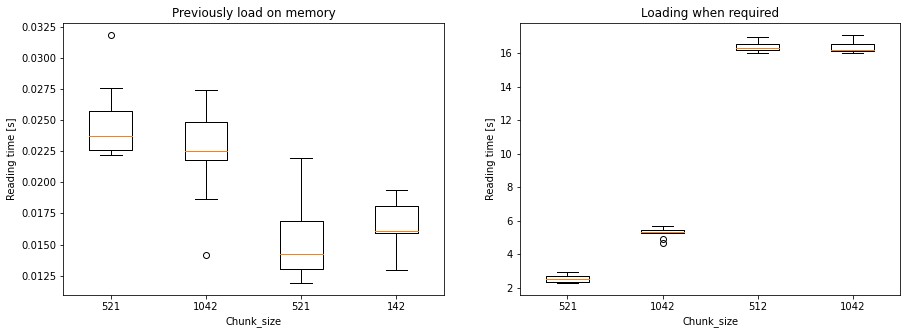

In [41]:
times_plot = [times1, times2, times3, times4, times5, times6, times7, times8]

t_loaded = [t for t in times_plot if t.loaded_in_memory]
t_not_loaded = [t for t in times_plot if not t.loaded_in_memory]

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Previously load on memory')
ax[1].set_title('Loading when required')

for i, t_list in enumerate([t_loaded, t_not_loaded]):
    ax[i].boxplot([t.times for t in t_list])
    ax[i].set_xticklabels([t.chunk_size for t in t_list])
    ax[i].set_xlabel('Chunk_size')
    ax[i].set_ylabel('Reading time [s]')
    
plt.show()

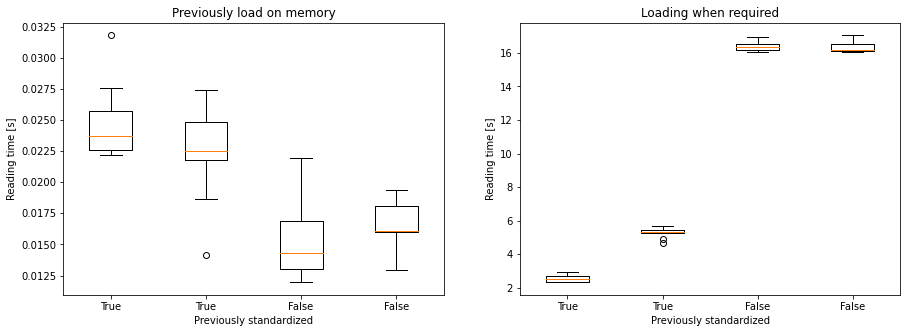

In [42]:
times_plot = [times1, times2, times3, times4, times5, times6, times7, times8]

t_loaded = [t for t in times_plot if t.loaded_in_memory]
t_not_loaded = [t for t in times_plot if not t.loaded_in_memory]

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Previously load on memory')
ax[1].set_title('Loading when required')

for i, t_list in enumerate([t_loaded, t_not_loaded]):
    ax[i].boxplot([t.times for t in t_list])
    ax[i].set_xticklabels([t.standardized for t in t_list])
    ax[i].set_xlabel('Previously standardized')
    ax[i].set_ylabel('Reading time [s]')
    
plt.show()

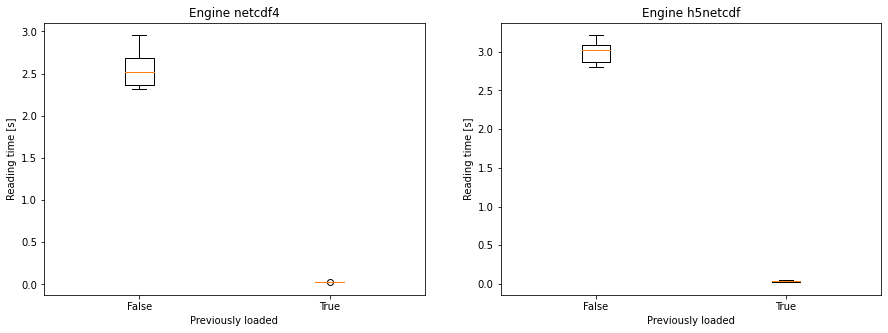

In [50]:
times_plot = [times1, times2, times6, times7, times8, times9]

t_loaded = [times1, times2]
t_not_loaded = [times9, times10]

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('Engine netcdf4')
ax[1].set_title('Engine h5netcdf')

for i, t_list in enumerate([t_loaded, t_not_loaded]):
    ax[i].boxplot([t.times for t in t_list])
    ax[i].set_xticklabels([t.loaded_in_memory for t in t_list])
    ax[i].set_xlabel('Previously loaded')
    ax[i].set_ylabel('Reading time [s]')
    
plt.show()

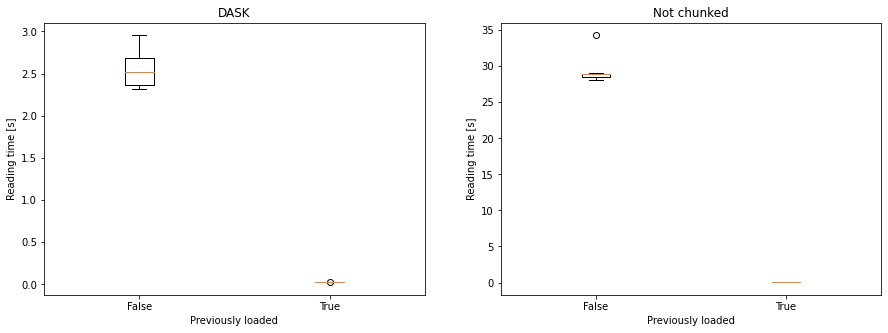

In [51]:
times_plot = [times1, times2, times6, times7, times8, times9]

t_loaded = [times1, times2]
t_not_loaded = [times11, times12]

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title('DASK')
ax[1].set_title('Not chunked')

for i, t_list in enumerate([t_loaded, t_not_loaded]):
    ax[i].boxplot([t.times for t in t_list])
    ax[i].set_xticklabels([t.loaded_in_memory for t in t_list])
    ax[i].set_xlabel('Previously loaded')
    ax[i].set_ylabel('Reading time [s]')
    
plt.show()

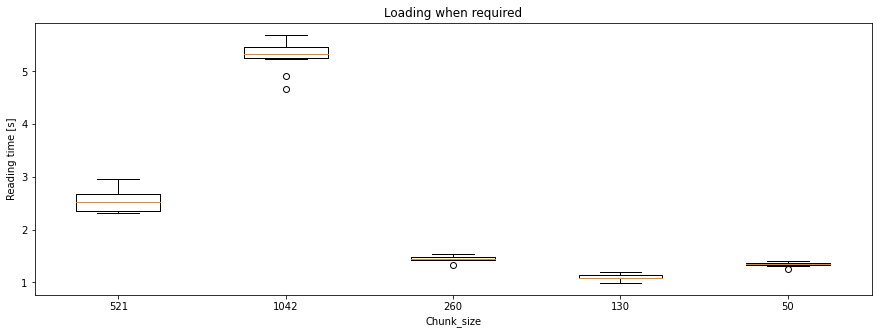

In [85]:
times_plot = [times1, times2, times3, times4,  times6,  times8, times15, times16, times17]

t_loaded = [t for t in times_plot if t.loaded_in_memory]
t_not_loaded = [t for t in times_plot if not t.loaded_in_memory]

fig, ax = plt.subplots(1,1,figsize=(15,5))

#ax[0].set_title('Previously load on memory')
ax.set_title('Loading when required')

for i, t_list in enumerate([t_not_loaded]):
    ax.boxplot([t.times for t in t_list])
    ax.set_xticklabels([t.chunk_size for t in t_list])
    ax.set_xlabel('Chunk_size')
    ax.set_ylabel('Reading time [s]')
    
plt.show()

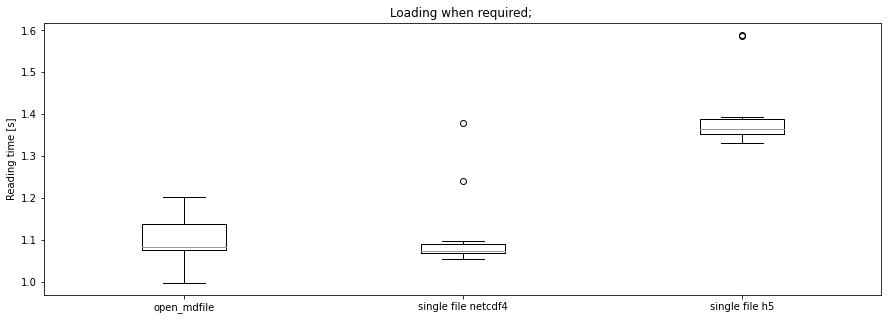

In [100]:
times_plot = [times16, times18, times19]
fig, ax = plt.subplots(1,1,figsize=(15,5))

#ax[0].set_title('Previously load on memory')
ax.set_title('Loading when required; ')

for i, t_list in enumerate([times_plot]):
    ax.boxplot([t.times for t in t_list])
    ax.set_xticklabels(['open_mdfile', 'single file netcdf4', 'single file h5'])
    ax.set_ylabel('Reading time [s]')
    
plt.show()

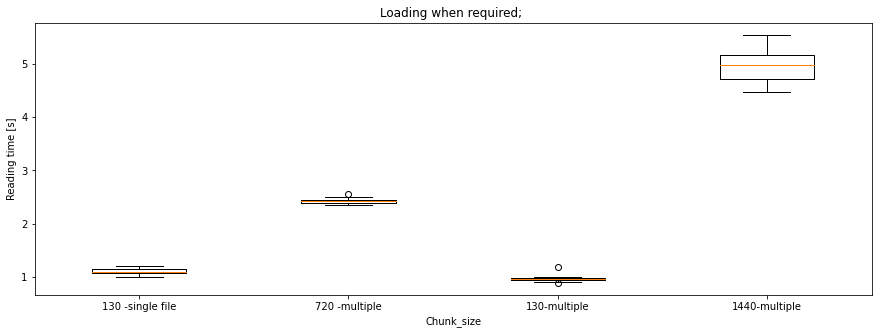

In [124]:
times_plot = [times16, times20, times21, times23]
fig, ax = plt.subplots(1,1,figsize=(15,5))

#ax[0].set_title('Previously load on memory')
ax.set_title('Loading when required; ')

for i, t_list in enumerate([times_plot]):
    ax.boxplot([t.times for t in t_list])
    ax.set_xticklabels(['130 -single file', '720 -multiple', '130-multiple', '1440-multiple'])
    ax.set_xlabel('Chunk_size')
    ax.set_ylabel('Reading time [s]')
    
plt.show()

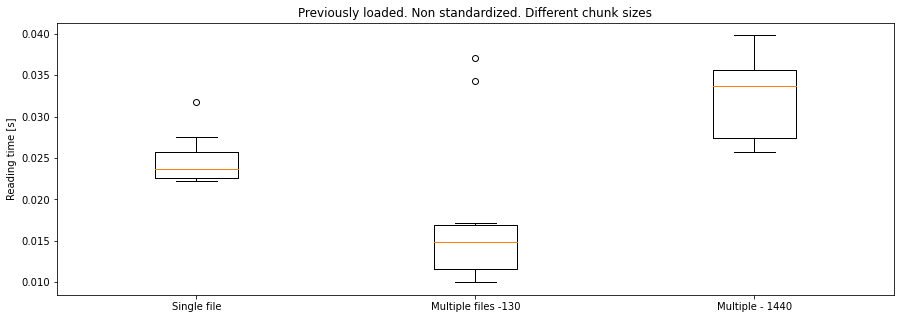

In [125]:
times_plot = [times2, times22, times24]
fig, ax = plt.subplots(1,1,figsize=(15,5))

#ax[0].set_title('Previously load on memory')
ax.set_title('Previously loaded. Non standardized. Different chunk sizes')

for i, t_list in enumerate([times_plot]):
    ax.boxplot([t.times for t in t_list])
    ax.set_xticklabels(['Single file', 'Multiple files -130', 'Multiple - 1440'])
    ax.set_ylabel('Reading time [s]')
    
plt.show()

Comments:
* Loading the data previously is the most significant difference regarding the total training time.

* Chunking the data has a large effect when it is not previously loaded. Also, the chunk size affects the reading time.

* Using previously standardized data instead of performing the standardization for each batch helps reducing the time. 

* Switching from netcdf4 to h5netcdf does not seem to provide any special advantage.